In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt
import fitsio
import glob

import numpy as np
import healpy as hp
import xlens
import treecorr
import astropy.io.ascii as pyascii
import numpy.lib.recfunctions as rfn
from lsst.geom import degrees

field_list = ["spring1", "spring2", "spring3", "autumn1", "autumn2", "hectomap"]

In [39]:
data = []
for field in field_list:
    fname = f"/gpfs02/work/xiangchong.li/work/hsc_data/s23b/db_star/fields/{field}.fits"
    data.append(fitsio.read(fname))
data = rfn.stack_arrays(data, usemask=False)
snr = data["i_psfflux_flux"] / data["i_psfflux_fluxerr"]
nbins = 12
cor = treecorr.GGCorrelation(nbins=nbins, min_sep=0.25, max_sep=360.0, sep_units="arcmin")
ra = data["i_ra"]
dec = data["i_dec"]
psf_mxx = data["i_hsmpsfmoments_shape11"]
psf_myy = data["i_hsmpsfmoments_shape22"]
psf_mxy = data["i_hsmpsfmoments_shape12"]

e1p2 = (psf_mxx - psf_myy) / (psf_mxx + psf_myy)
e2p2 = psf_mxy / (psf_mxx + psf_myy) * 2.0

star_mxx = data["i_hsmsourcemoments_shape11"]
star_myy = data["i_hsmsourcemoments_shape22"]
star_mxy = data["i_hsmsourcemoments_shape12"]

e1s2 = (star_mxx - star_myy) / (star_mxx + star_myy)
e2s2 = star_mxy / (star_mxx + star_myy) * 2.0

e1p4 = (
    data["i_higherordermomentspsf_40"] -
    data["i_higherordermomentspsf_04"]
)
e2p4 = 2.0 * (
    data["i_higherordermomentspsf_31"] +
    data["i_higherordermomentspsf_13"]
)

e1s4 = (
    data["i_higherordermomentssource_40"] -
    data["i_higherordermomentssource_04"]
)
e2s4 = 2.0 * (
    data["i_higherordermomentssource_31"] +
    data["i_higherordermomentssource_13"]
)
msk = (
    (~np.isnan(e1p2)) & 
    (~np.isnan(e1s2)) & 
    (~np.isnan(e1p4)) & 
    (~np.isnan(e1s4)) & 
    (~np.isnan(e2p2)) & 
    (~np.isnan(e2s2)) & 
    (~np.isnan(e2p4)) & 
    (~np.isnan(e2s4)) & 
    (data["i_calib_psf_reserved"]) & 
    (snr>180.0) 
)

ra = ra[msk]
dec = dec[msk]
e1p2 = e1p2[msk]
e2p2 = e2p2[msk]
e1p4 = e1p4[msk]
e2p4 = e2p4[msk]

e1s2 = e1s2[msk]
e2s2 = e2s2[msk]
e1s4 = e1s4[msk]
e2s4 = e2s4[msk]

catP2 = treecorr.Catalog(
    g1=e1p2, g2=-e2p2, 
    ra=ra, dec=dec, 
    ra_units="deg", 
    dec_units="deg"
)
catQ2 = treecorr.Catalog(
    g1=e1p2 - e1s2,
    g2=-(e2p2 - e2s2),
    ra=ra,
    dec=dec,
    ra_units="deg",
    dec_units="deg",
)

catP4 = treecorr.Catalog(
    g1=e1p4, g2=-e2p4, 
    ra=ra, dec=dec, 
    ra_units="deg", 
    dec_units="deg"
)
catQ4 = treecorr.Catalog(
    g1=e1p4 - e1s4,
    g2=-(e2p4 - e2s4),
    ra=ra,
    dec=dec,
    ra_units="deg",
    dec_units="deg",
)

# Define pairs to compute correlations
pairs = [
    ("P2", "P2"),
    ("P2", "P4"),
    ("P2", "Q2"),
    ("P2", "Q4"),
    ("P4", "P4"),
    ("P4", "Q2"),
    ("P4", "Q4"),
    ("Q2", "Q2"),
    ("Q2", "Q4"),
    ("Q4", "Q4"),
]

# Map names to actual catalogs
catalogs = {
    "P2": catP2,
    "P4": catP4,
    "Q2": catQ2,
    "Q4": catQ4,
}

# Dictionary to store results
res = {}
err = {}

for name1, name2 in pairs:
    cor = treecorr.GGCorrelation(nbins=nbins, min_sep=0.25, max_sep=360.0, sep_units="arcmin")
    cor.process(catalogs[name1], catalogs[name2])
    key = f"{name1}{name2}"
    res[key] = cor.xip
    err[key] = np.sqrt(cor.varxip / 2.0)

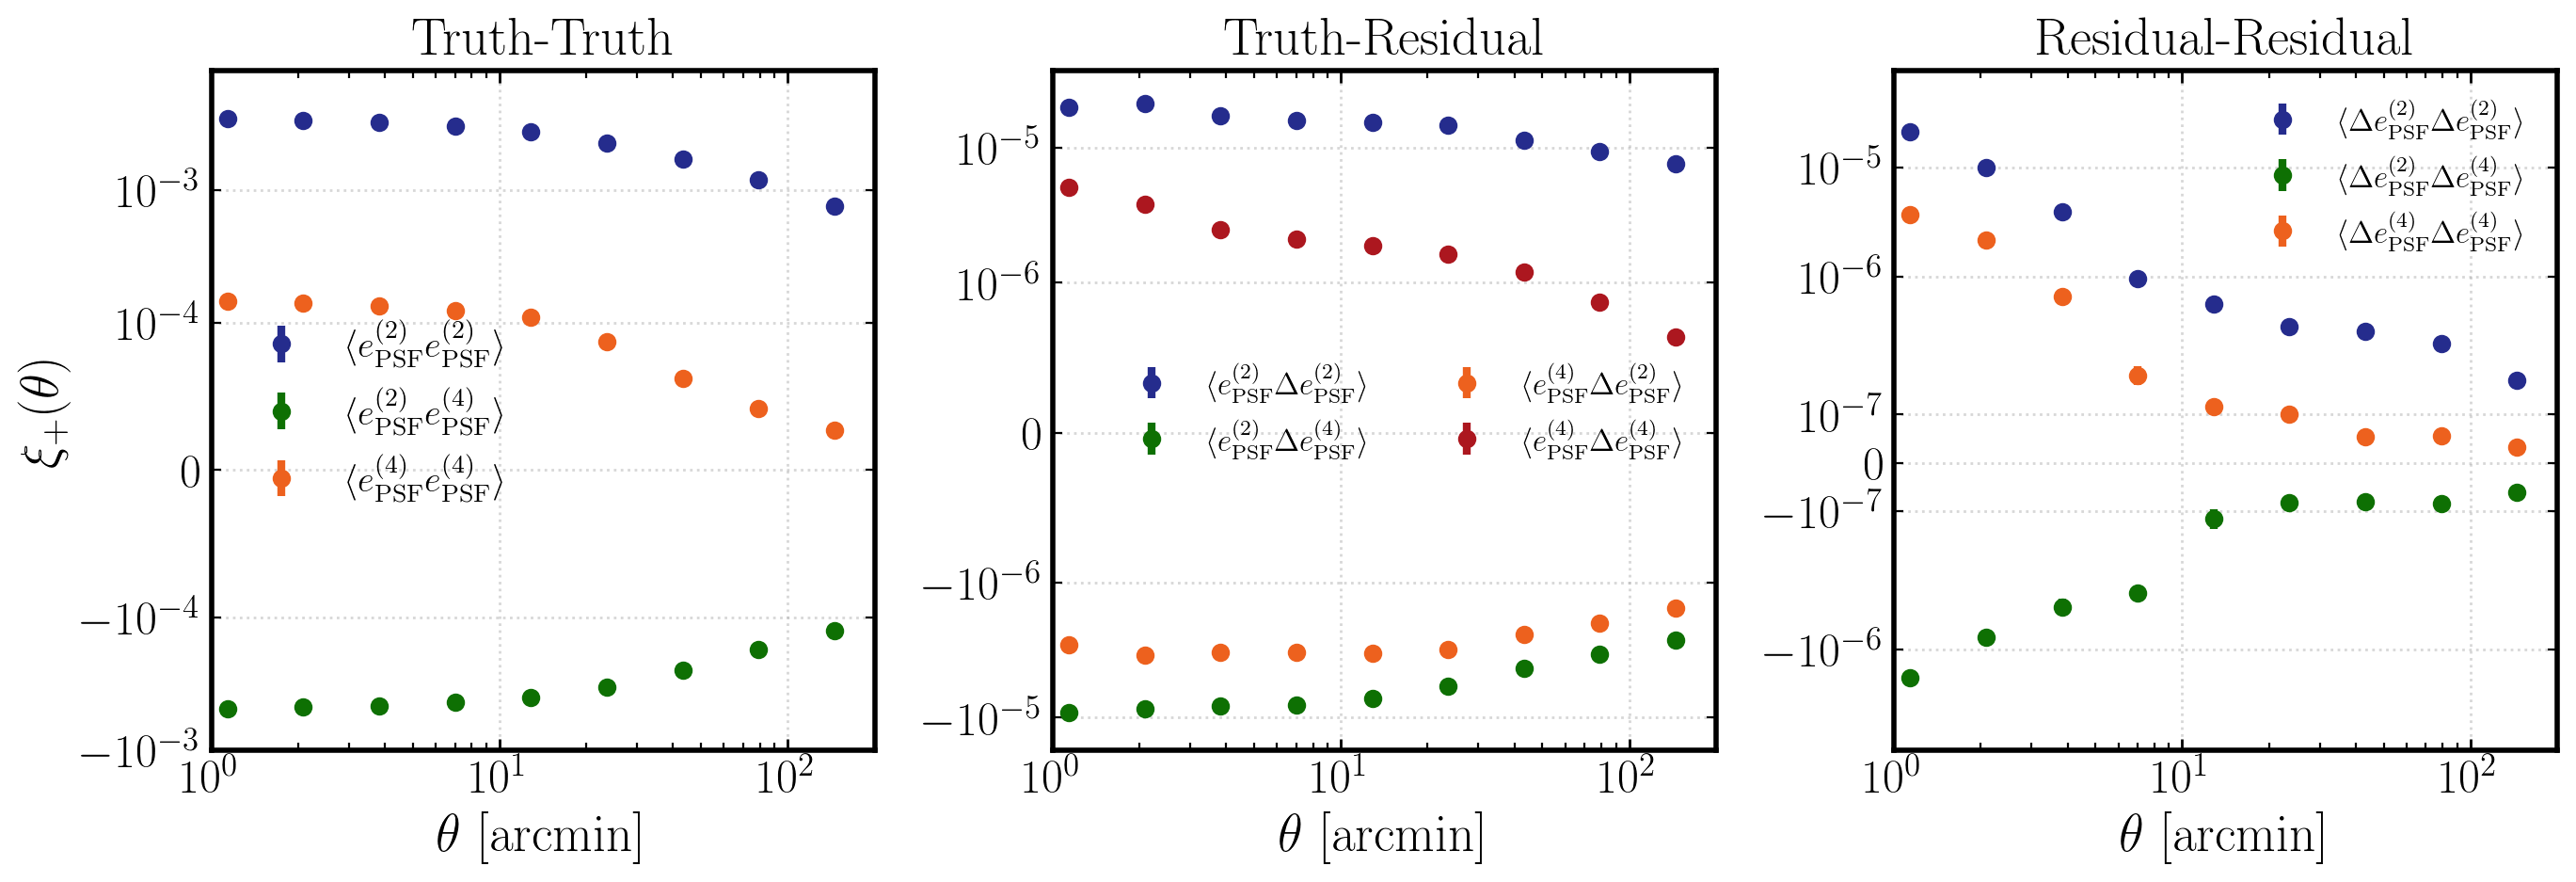

In [40]:
plt.close()
theta = cor.rnom
# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharex=True)

# --- Panel 1: Truth-Truth ---
ax = axes[0]
ax.errorbar(theta, res["P2P2"], yerr=err["P2P2"], fmt='o', label=r'$\langle e^{(2)}_{\rm PSF} e^{(2)}_{\rm PSF} \rangle$')
ax.errorbar(theta, res["P2P4"], yerr=err["P2P4"], fmt='o', label=r'$\langle e^{(2)}_{\rm PSF}e^{(4)}_{\rm PSF} \rangle$')
ax.errorbar(theta, res["P4P4"], yerr=err["P4P4"], fmt='o', label=r'$\langle e^{(4)}_{\rm PSF}e^{(4)}_{\rm PSF} \rangle$')
ax.set_title("Truth-Truth")
ax.set_xscale("log")
ax.set_yscale("symlog", linthresh=1e-4)
ax.set_xlim(1, 200)
ax.set_ylim(-1e-3, 8e-3)
ax.set_xlabel(r"$\theta$ [arcmin]")
ax.set_ylabel(r"$\xi_{+}(\theta)$")
ax.legend(fontsize=14, loc="center left", ncol=1, frameon=False)
ax.grid(True, linestyle=':')


# --- Panel 2: Truth-Residual ---
ax = axes[1]
ax.errorbar(theta, res["P2Q2"], yerr=err["P2Q2"], fmt='o', label=r'$\langle e^{(2)}_{\rm PSF}\Delta e^{(2)}_{\rm PSF} \rangle$')
ax.errorbar(theta, res["P2Q4"], yerr=err["P2Q4"], fmt='o', label=r'$\langle e^{(2)}_{\rm PSF}\Delta e^{(4)}_{\rm PSF} \rangle$')
ax.errorbar(theta, res["P4Q2"], yerr=err["P4Q2"], fmt='o', label=r'$\langle e^{(4)}_{\rm PSF}\Delta e^{(2)}_{\rm PSF} \rangle$')
ax.errorbar(theta, res["P4Q4"], yerr=err["P4Q4"], fmt='o', label=r'$\langle e^{(4)}_{\rm PSF}\Delta e^{(4)}_{\rm PSF} \rangle$')
ax.set_title("Truth-Residual")
ax.set_xscale("log")
ax.set_yscale("symlog", linthresh=1e-6)
ax.set_xlabel(r"$\theta$ [arcmin]")
ax.legend(fontsize=12, ncol=2, frameon=False)
ax.grid(True, linestyle=':')

# --- Panel 3: Residual-Residual ---
ax = axes[2]
ax.errorbar(theta, res["Q2Q2"], yerr=err["Q2Q2"], fmt='o', label=r'$\langle \Delta e^{(2)}_{\rm PSF}\Delta e^{(2)}_{\rm PSF} \rangle$')
ax.errorbar(theta, res["Q2Q4"], yerr=err["Q2Q4"], fmt='o', label=r'$\langle \Delta e^{(2)}_{\rm PSF}\Delta e^{(4)}_{\rm PSF} \rangle$')
ax.errorbar(theta, res["Q4Q4"], yerr=err["Q4Q4"], fmt='o', label=r'$\langle \Delta e^{(4)}_{\rm PSF}\Delta e^{(4)}_{\rm PSF} \rangle$')
ax.set_title("Residual-Residual")
ax.set_xscale("log")
ax.set_yscale("symlog", linthresh=2.5e-7)
ax.set_xlabel(r"$\theta$ [arcmin]")
ax.legend(fontsize=12, ncol=1, frameon=False)
ax.grid(True, linestyle=':')

plt.tight_layout()

In [41]:
# Matrix entry order: P2, P4, Q2, Q4
corr_labels = {
    ("P2", "P2"): "P2P2",
    ("P2", "P4"): "P2P4",
    ("P2", "Q2"): "P2Q2",
    ("P2", "Q4"): "P2Q4",
    ("P4", "P4"): "P4P4",
    ("P4", "Q2"): "P4Q2",
    ("P4", "Q4"): "P4Q4",
    ("Q2", "Q2"): "Q2Q2",
    ("Q2", "Q4"): "Q2Q4",
    ("Q4", "Q4"): "Q4Q4",
}

# Define variable names and initialize storage
vars = ["P2", "P4", "Q2", "Q4"]
n_bins = len(res["P2P2"])
matrices = []

# Loop over each angular bin
for i_bin in range(n_bins):
    mat = np.zeros((4, 4))
    for i in range(4):
        for j in range(4):
            key = tuple(sorted((vars[i], vars[j])))
            label = corr_labels.get(key)
            mat[i, j] = res[label][i_bin]
    matrices.append(mat)

In [42]:
istart = 3; iend = -2

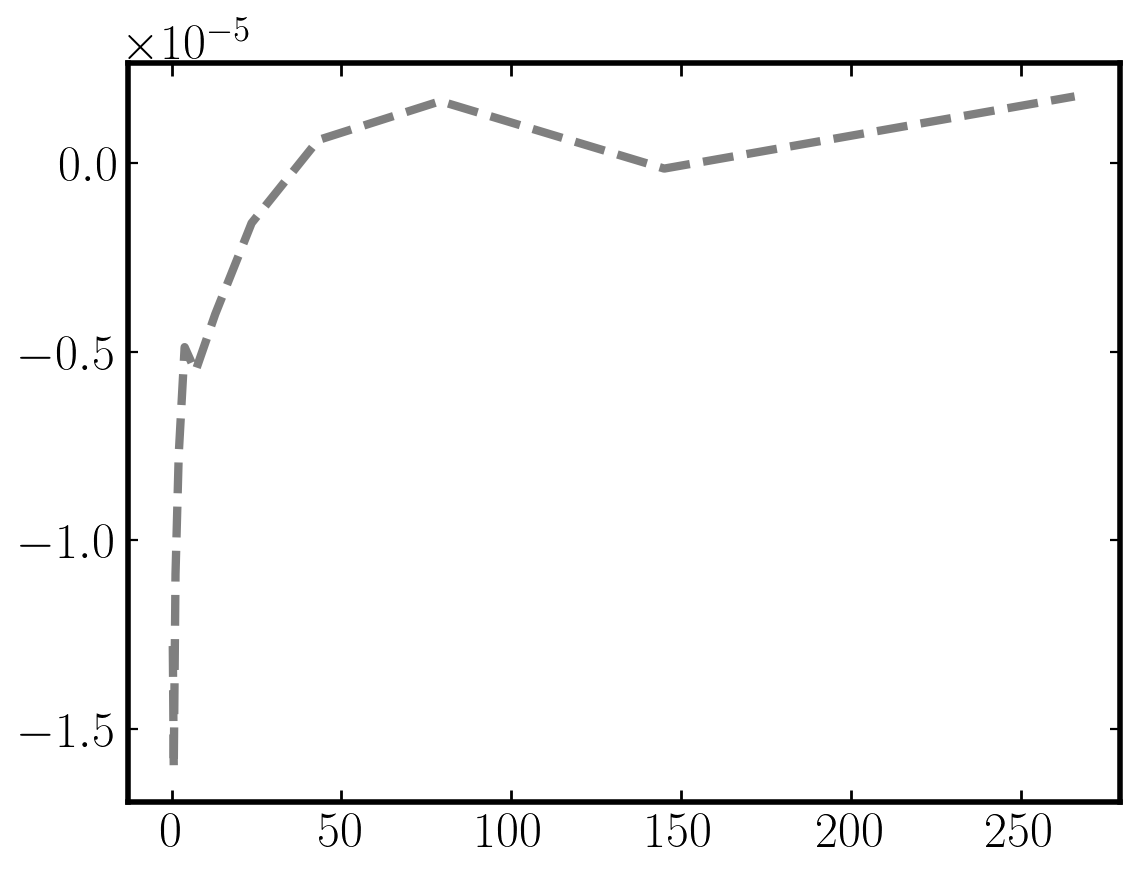

In [43]:
plt.close()
out = fitsio.read("/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_anacal3/psfstar.fits")
out = np.sum(out, axis=0)
ii = 0
plt.plot(theta, out[ii] / out[-1], color="black", alpha=0.5, ls="--")

In [44]:
out = fitsio.read("/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_anacal3/psfstar.fits")
out = np.sum(out, axis=0)
dd = np.zeros((12, 4))
for i in range(4):
    dd[:, i] = out[i] / out[-1]

In [45]:
# after inverse matrix multiplcation
out = fitsio.read("/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_anacal3/psfstar.fits")[:, :, istart:iend]
nboot = 400
nreal = out.shape[0]
ndd = len(theta[istart: iend])
y_boot = np.empty((nboot, 4, ndd))
for i in range(nboot):
    idx = np.random.choice(nreal, size=nreal, replace=True)
    res = np.sum(out[idx], axis=0)
    cc = np.empty((4, ndd))
    for _ in range(4):
        cc[_] = res[_] / res[-1]
    cc = cc.T
    yy = np.zeros((ndd, 4))
    for _ in range(ndd):
        yy[_] = A[_] @ cc[_]
    y_boot[i] = yy.T
stds = np.std(y_boot, axis=0)
y_flat = y_boot.reshape(nboot, -1)
cov = np.cov(y_flat, rowvar=False)

In [46]:
# before inverse matrix multiplcation
out = fitsio.read("/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_anacal3/psfstar.fits")[:, :, istart:iend]
nboot = 10000
ndd = len(theta[istart: iend])
nreal = out.shape[0]
y_boot = np.empty((nboot, ndd, 4))
for i in range(nboot):
    idx = np.random.choice(nreal, size=nreal, replace=True)
    res = np.sum(out[idx], axis=0)
    for _ in range(4):
        y_boot[i, :, _] = res[_] / res[-1]
y_flat = y_boot.reshape(nboot, -1)
cov = np.cov(y_flat, rowvar=False)
cov = cov * 705 / (704 - ndd * 4)

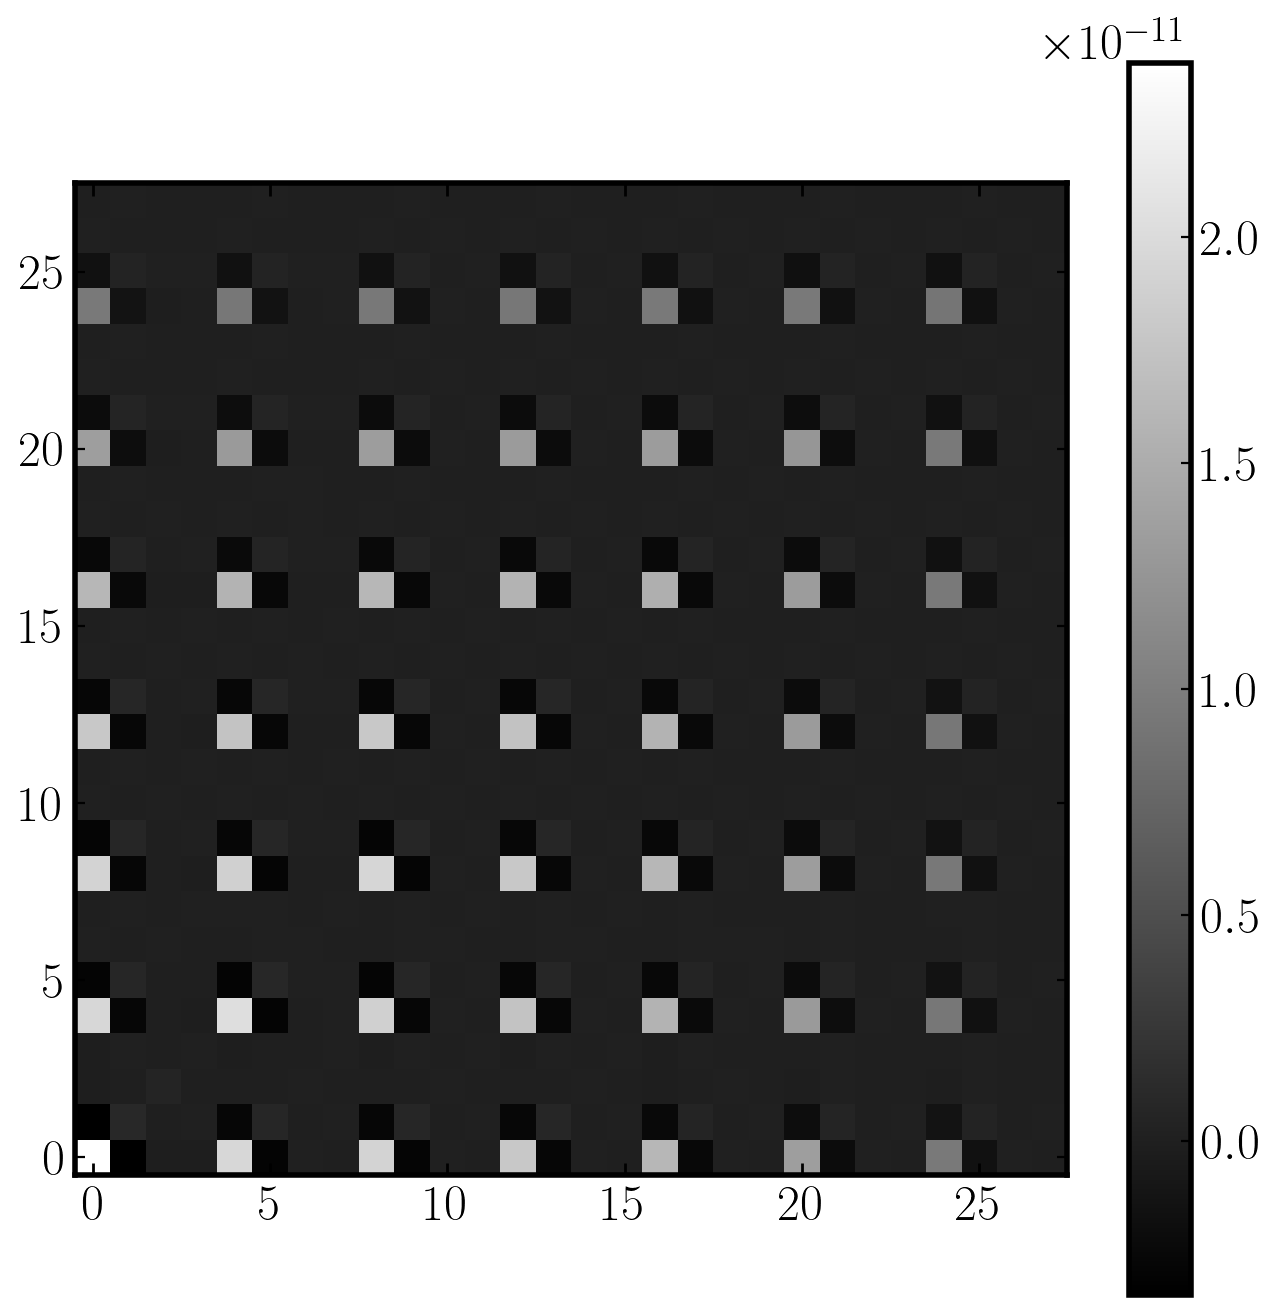

In [47]:
from astropy.visualization import ZScaleInterval
interval = ZScaleInterval()
vmin, vmax = interval.get_limits(cov)

fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(cov, origin='lower', cmap='gray')
plt.colorbar(im)

In [48]:
from scipy.linalg import block_diag

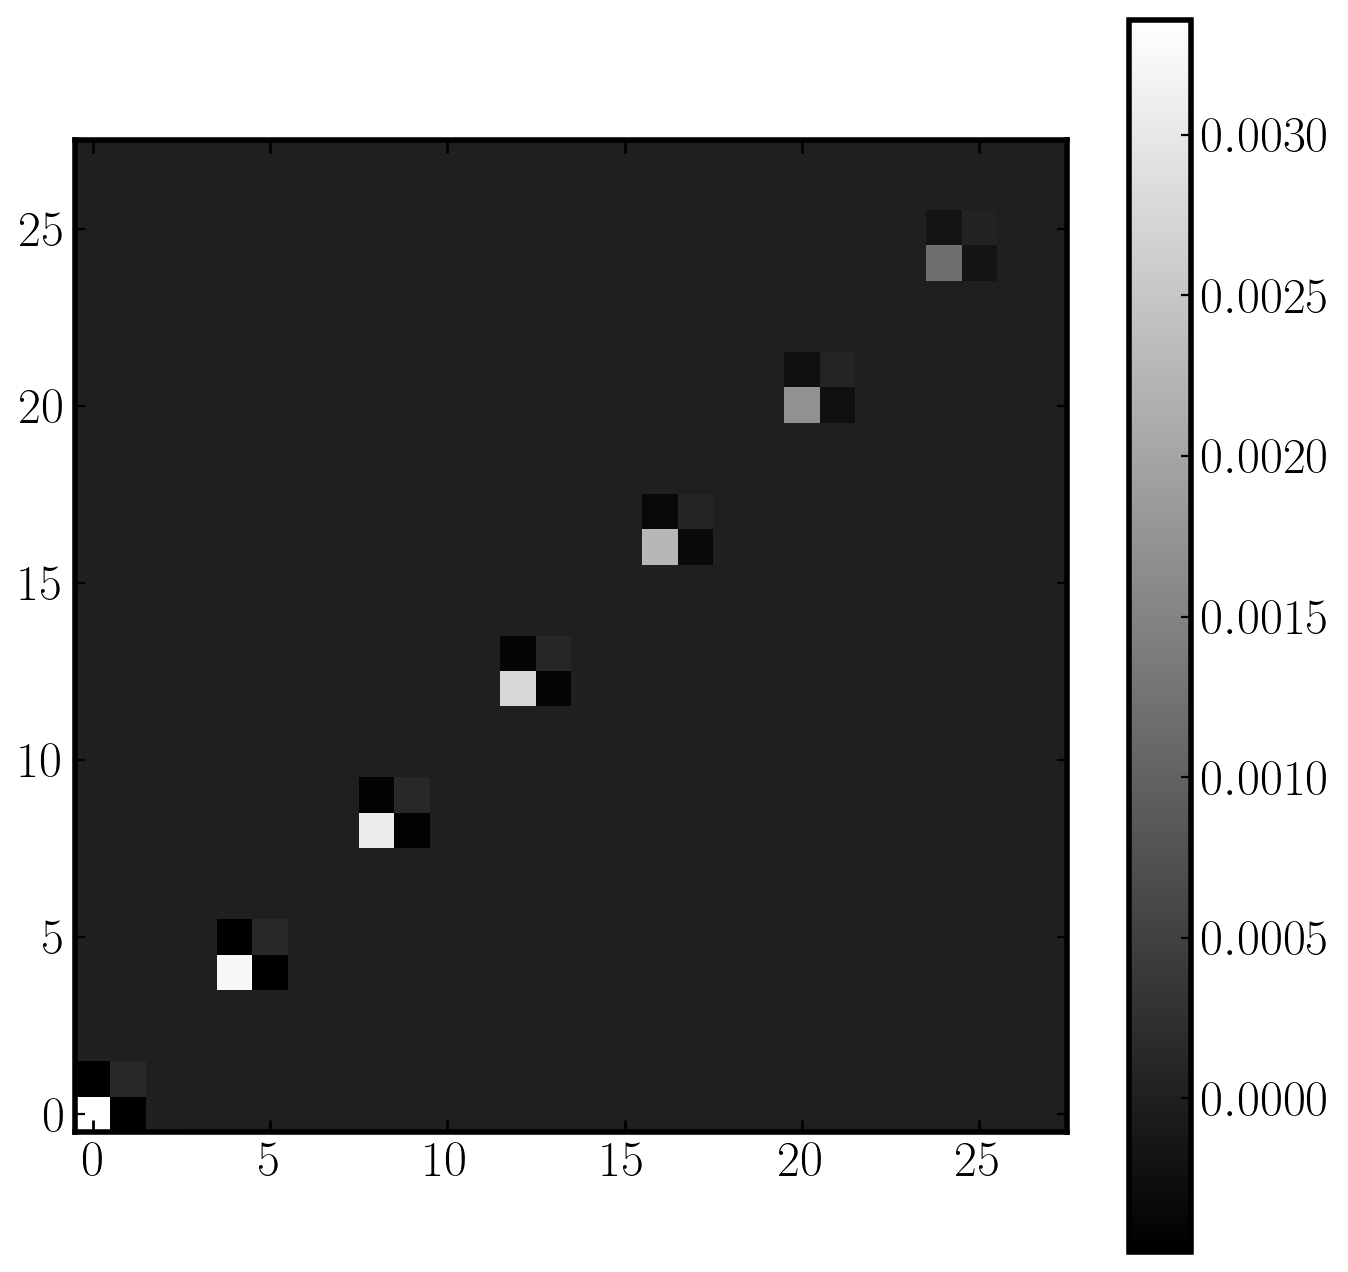

In [49]:
mat = block_diag(*np.stack(matrices)[istart: iend])
interval = ZScaleInterval()
vmin, vmax = interval.get_limits(cov)

fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(mat, origin='lower', cmap='gray')
plt.colorbar(im)

In [50]:
y = np.ravel(dd[istart:iend])

In [51]:
import emcee
from scipy.stats import multivariate_normal
from scipy.linalg import cho_factor, cho_solve

cho_cov, lower = cho_factor(cov)

def tile_params(params):
    """Convert [alpha2, alpha4, beta2, beta4] to (40,) vector by tiling 10 times"""
    return np.tile(params, ndd)

def log_likelihood(params):
    model = mat @ tile_params(params)
    residual = y - model
    # Solve cov^{-1} * residual using Cholesky
    whitened = cho_solve((cho_cov, lower), residual)
    return -0.5 * np.dot(residual, whitened)

def log_prior(params):
    if np.all(np.abs(params) < 10): 
        return 0.0
    return -np.inf

def log_posterior(params):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params)

# Initial position of walkers
ndim = 4
nwalkers = 32
p0 = np.random.randn(nwalkers, ndim) * 0.1

# Set up the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)

# Run MCMC
nsteps = 8000
_ = sampler.run_mcmc(p0, nsteps, progress=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:15<00:00, 524.69it/s]


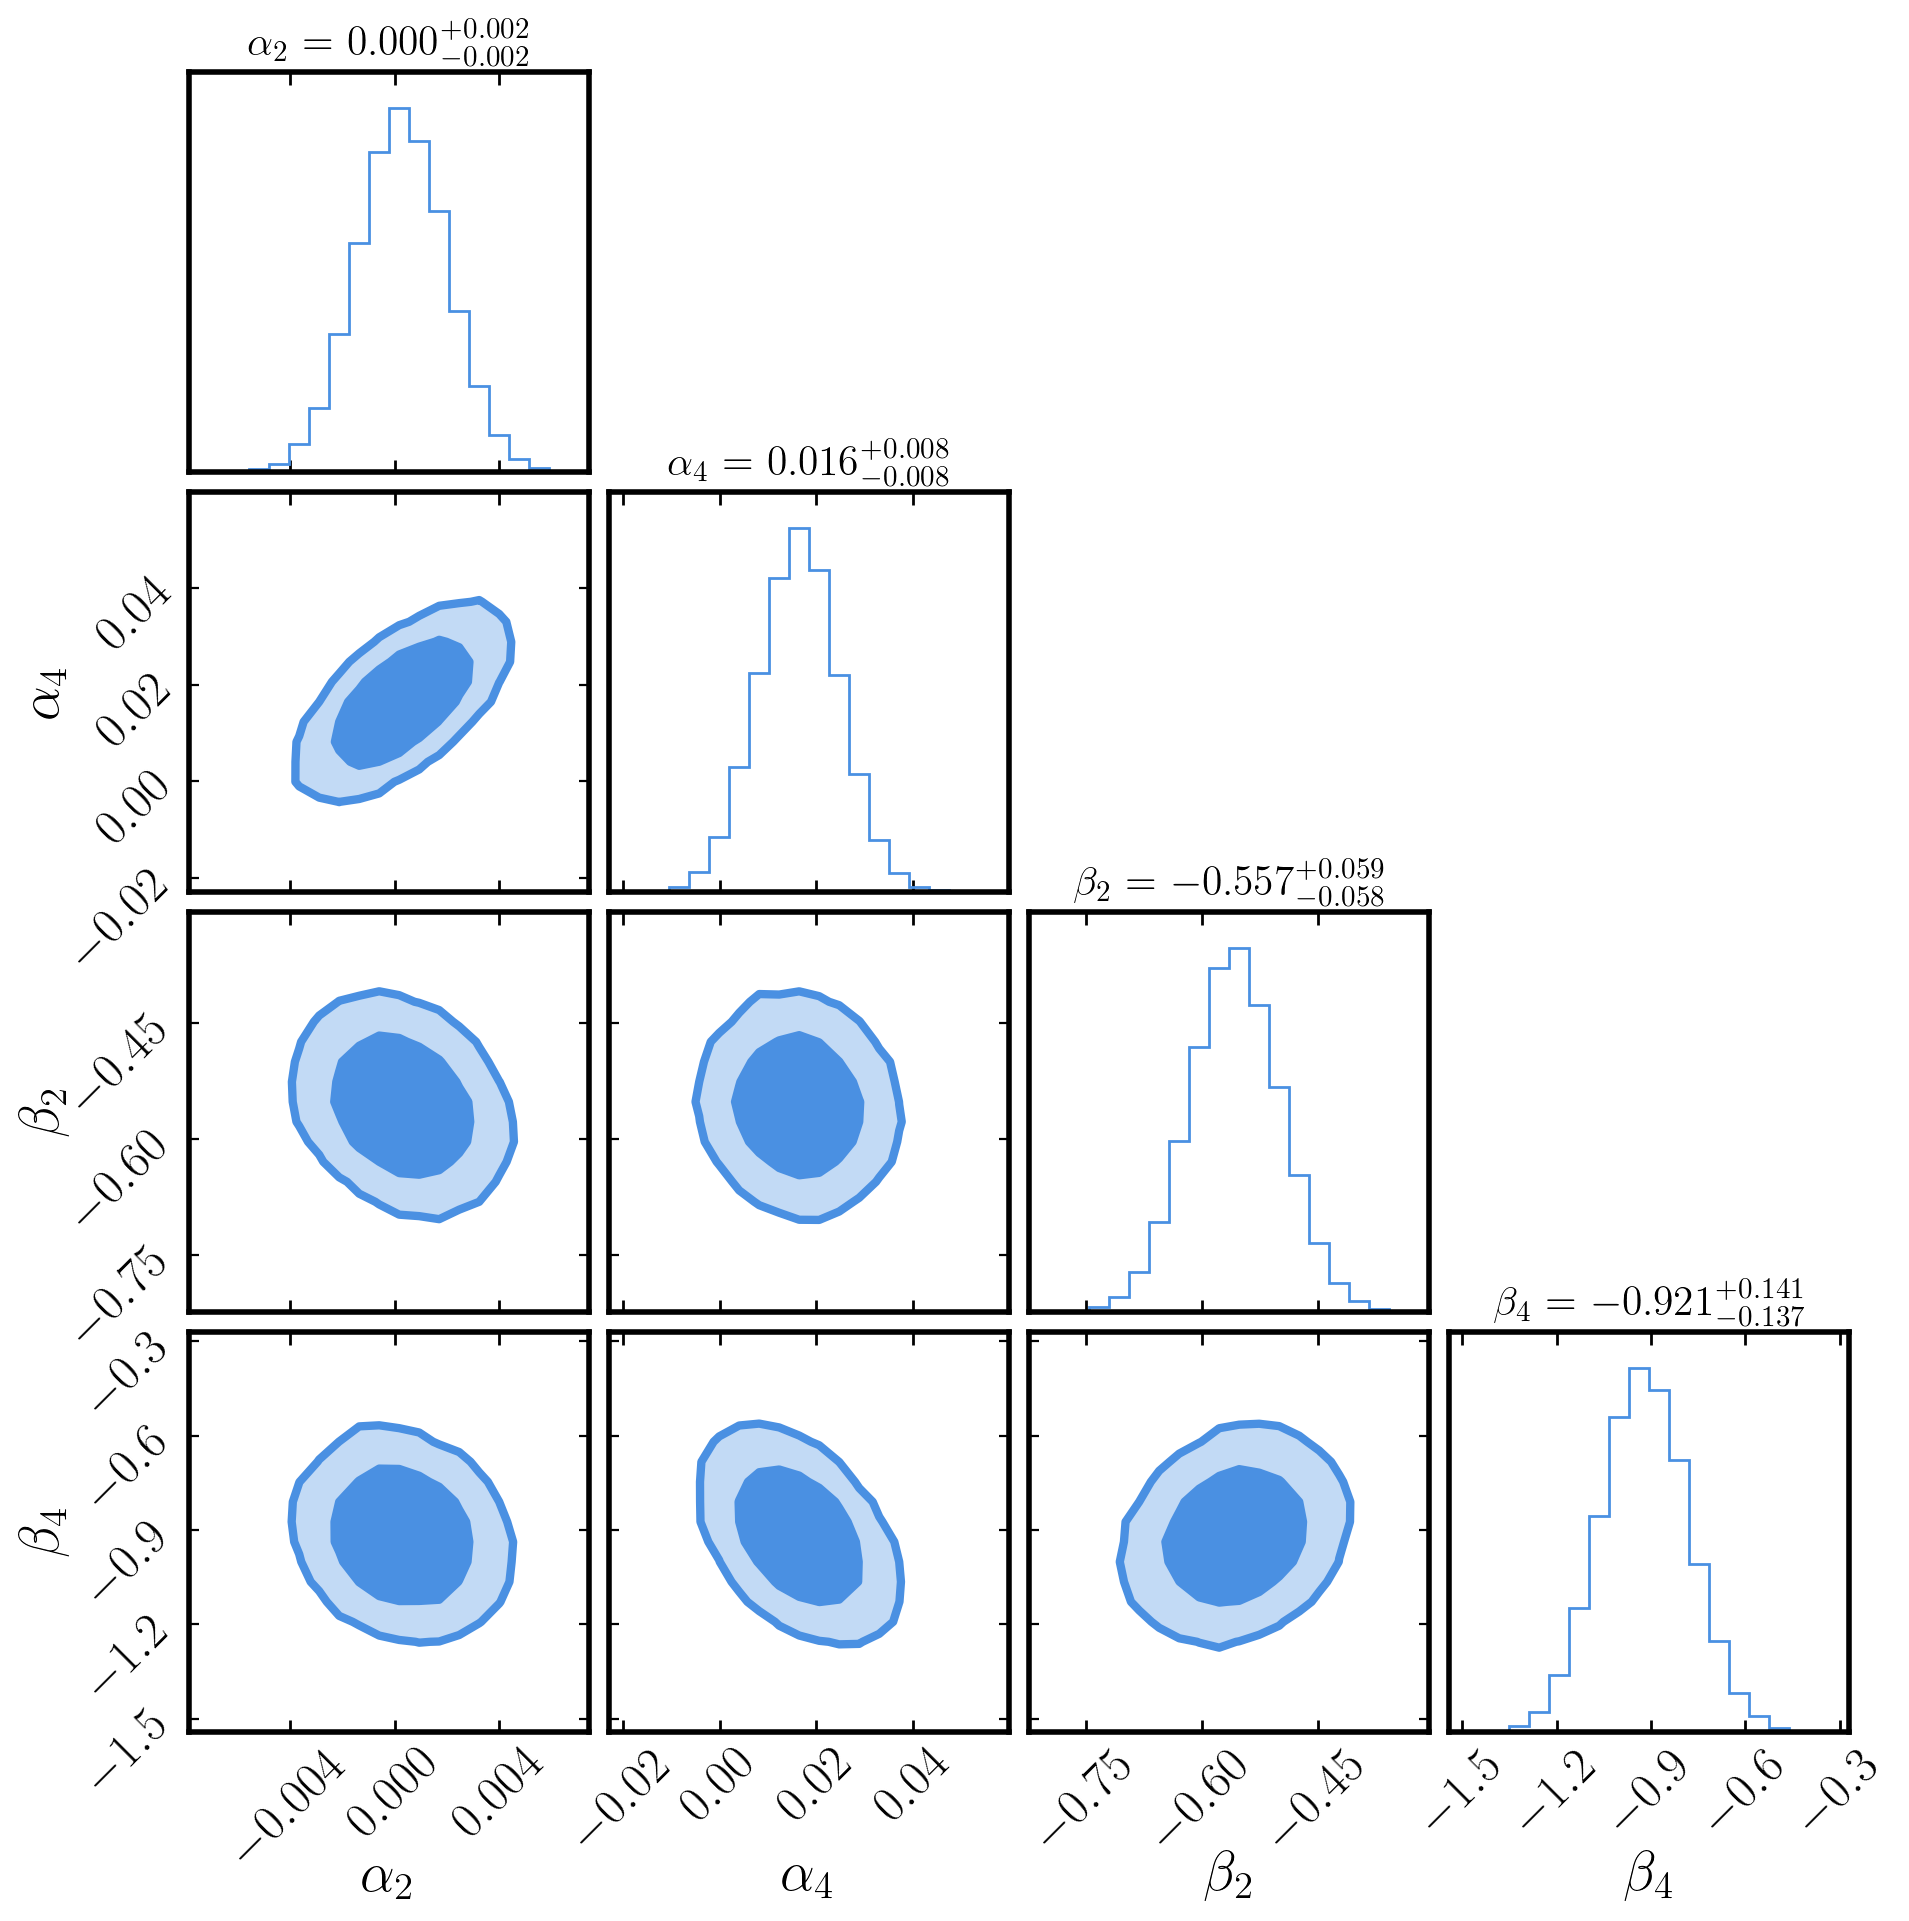

In [52]:
# Get the samples
samples = sampler.get_chain(discard=800, flat=True)
import corner
import matplotlib.pyplot as plt
# Parameter labels
param_names = [r"$\alpha_2$", r"$\alpha_4$", r"$\beta_2$", r"$\beta_4$"]

# Corner plot with improved settings
fig = corner.corner(
    samples,
    labels=param_names,
    show_titles=True,
    title_fmt=".3f",
    title_kwargs={"fontsize": 15},
    color="#4A90E2",
    plot_datapoints=False,   # Do not show the sample points
    fill_contours=True,      # Fill the contours for visual clarity
    levels=(0.68, 0.95),     # Show 68% and 95% contours
)
fig.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

In [53]:
for i, name in enumerate(param_names):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    print(f"{name}: {mcmc[1]:.4f} (+{q[1]:.4f}/-{q[0]:.4f})")

$\alpha_2$: 0.0003 (+0.0017/-0.0017)
$\alpha_4$: 0.0164 (+0.0082/-0.0084)
$\beta_2$: -0.5573 (+0.0594/-0.0580)
$\beta_4$: -0.9212 (+0.1405/-0.1374)


In [54]:
# Get log-probabilities for all samples
log_probs = sampler.get_log_prob(discard=500, flat=True)
flat_samples = sampler.get_chain(discard=500, flat=True)

# Find the sample with the highest posterior probability
max_idx = np.argmax(log_probs)
best_fit_params = flat_samples[max_idx]
print("MAP estimate:", best_fit_params)

MAP estimate: [ 3.25006105e-04  1.65013911e-02 -5.59153150e-01 -9.16112694e-01]


In [55]:
params_best = best_fit_params
param_vector = np.tile(params_best, ndd)
# Predicted model
model = mat @ param_vector

# Residuals
residual = y - model

# Chi-square
chi2 = residual.T @ (np.linalg.inv(cov) @ residual)
print("Chi2:", chi2)

Chi2: 40.913683499208005


In [56]:
import scipy

In [57]:
scipy.stats.chi2.sf(chi2, ndd * 4)

0.05469196946553701

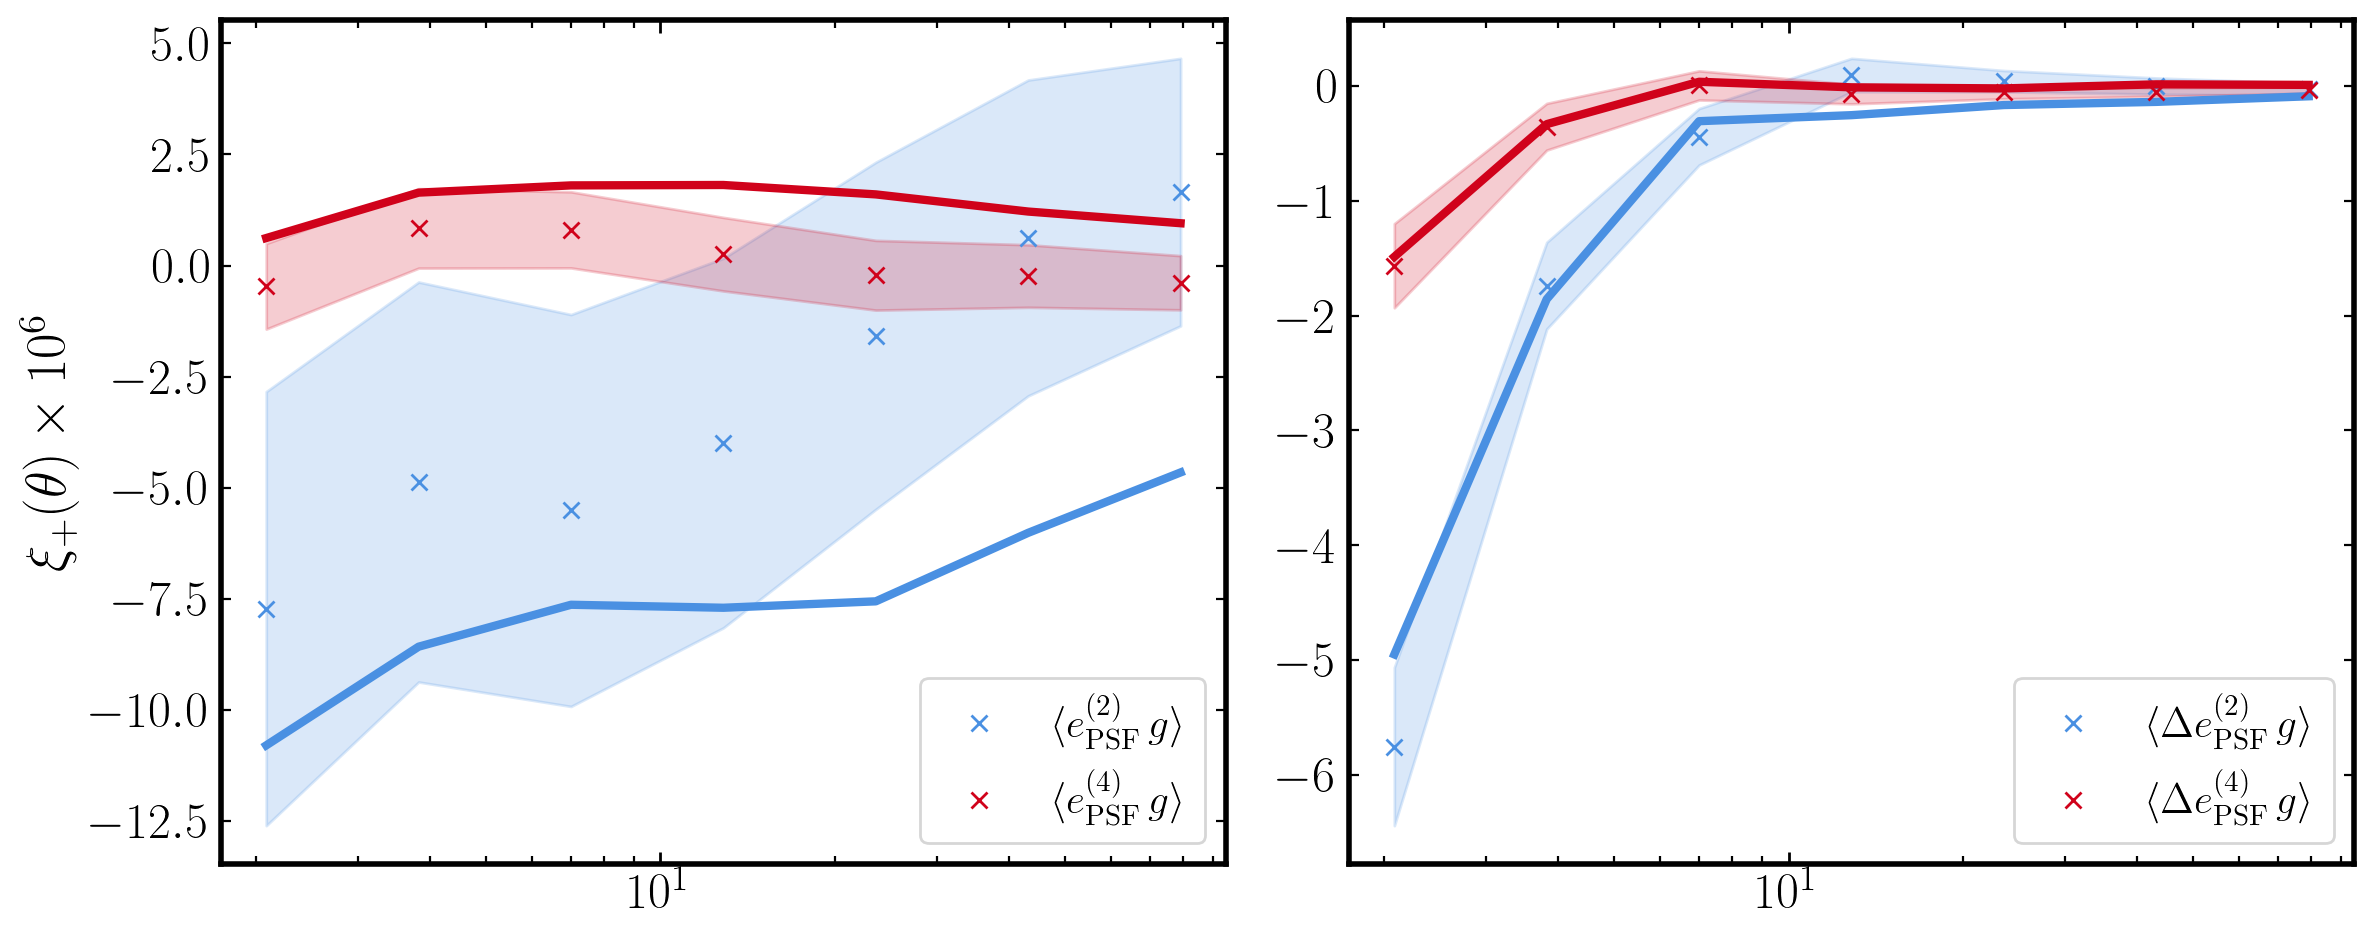

In [58]:
colors = ['#4A90E2', '#D0021B', '#4A90E2', '#D0021B']
labels = [
    r'$\langle e_{\rm PSF}^{(2)}\, g \rangle$',
    r'$\langle e_{\rm PSF}^{(4)}\, g \rangle$',
    r'$\langle \Delta e_{\rm PSF}^{(2)}\, g \rangle$',
    r'$\langle \Delta e_{\rm PSF}^{(4)}\, g \rangle$'
]

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

axes[0].set_xscale("log")
axes[0].set_ylabel(r"$\xi_+(\theta) \times 10^6$")
axes[1].set_xscale("log")

mul = 1e6
for idata in range(4):
    ax = axes[0] if idata in [0, 1] else axes[1]
    data = dd.T[idata][istart:iend] * mul
    color=colors[idata]
    mm = model.reshape(ndd, 4).T[idata] * mul
    std = np.sqrt(cov.diagonal().reshape(ndd, 4).T)[idata] * mul
    ax.plot(theta[istart:iend], mm, color=color)
    ax.plot(theta[istart:iend], data,  ls="", marker="x", color=color, label=labels[idata])
    ax.fill_between(theta[istart:iend], data-std, data+std, color=color, alpha=0.2)
    
axes[0].legend(fontsize=15)
axes[1].legend(fontsize=15)
plt.tight_layout()

(3.0, 100)

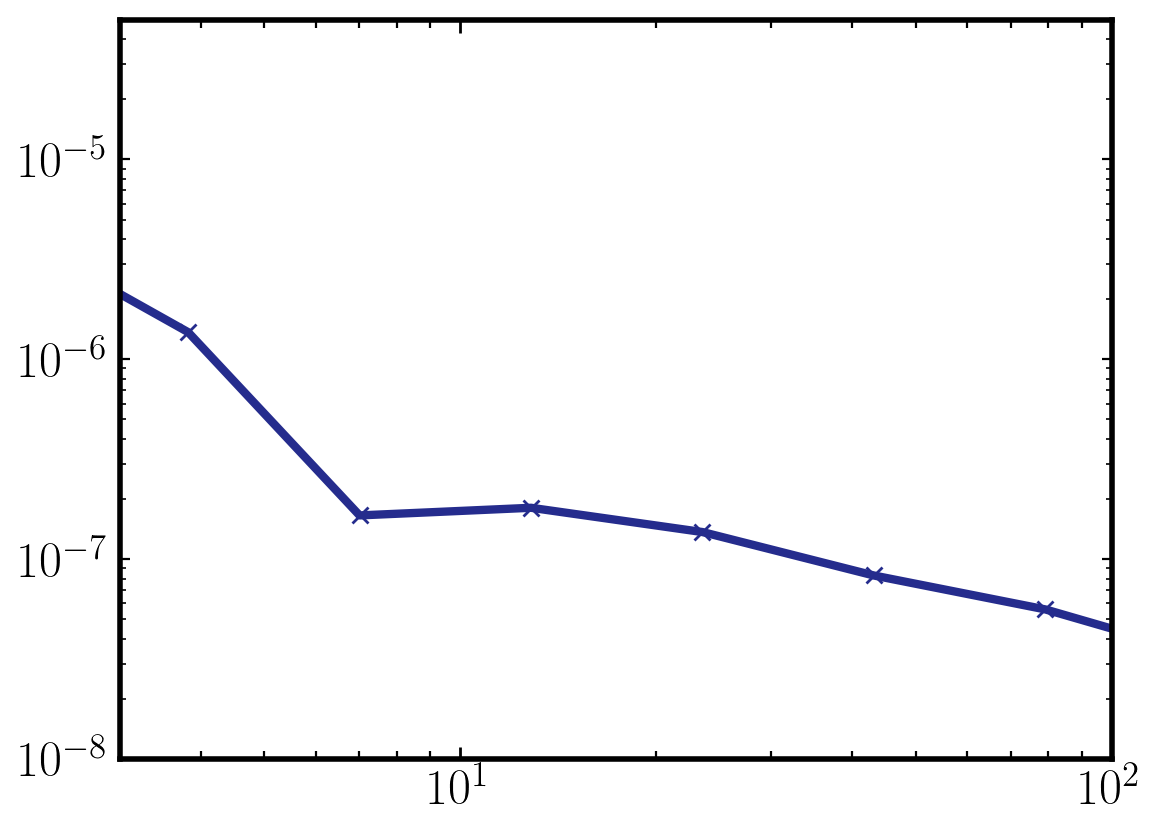

In [59]:
forward_matrices = np.stack(matrices)
xi_bias = best_fit_params @ (forward_matrices @ best_fit_params).T
plt.plot(theta, xi_bias, marker="x")
plt.xscale("log")
plt.yscale("log")
plt.ylim(1e-8, 5e-5)
plt.xlim(3.0, 100)